#Configuration de l'environnement de travail

In [0]:
#!rm -rf /content/melspectrogram/ #supprime le dossier melspectrogram si problèmes
!pip install librosa # installation de la librairie librosa
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset #téléchargement du jeu de données
!mkdir /content/melspectrogram #création du dossier qui contiendra les mel-spectrogrammes


Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 3166 (delta 3), reused 5 (delta 0), pack-reused 3157
Receiving objects: 100% (3166/3166), 23.92 MiB | 27.36 MiB/s, done.
Resolving deltas: 100% (72/72), done.


###Chargement des chemins de fichiers

Pour éviter d'avoir à recalculer constamment les mel-spectrogrammes, on les calcule une fois et on les sauvegarde dans le dossier melspectrogram. On commence par charger les chemins de fichiers.

In [0]:
import glob # librairie spécialisée dans la recherche de chemin
list_of_files = glob.glob("free-spoken-digit-dataset/recordings/*") #permet d'obtenir le chemin relatif de tous les fichiers du dossier recordings
print(list_of_files[:2])

['free-spoken-digit-dataset/recordings/6_yweweler_21.wav', 'free-spoken-digit-dataset/recordings/6_yweweler_13.wav']


In [0]:
n_files = len(list_of_files) # nombres de fichiers audios
print(n_files)

2000


###Exemple librairie librosa

On peut charger les fichiers audio au format .wav

In [0]:
import librosa
y, sr = librosa.load(list_of_files[3], sr= 8000) #y est le signal sous forme d'array numpy, sr est le taux d'échantillonage (vaut 8khz  d'après les indications github)
print(y, sr)

[-0.015625  -0.0078125 -0.015625  ... -0.015625  -0.0078125 -0.0078125] 8000


On peut calculer certaines caractéristiques des signaux audios, ici le melspectrogramme

In [0]:
import numpy as np
sp = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128) # calcul du melspectrogramme
s_dB = librosa.power_to_db(sp, ref=np.max) #conversion de l'amplitude en dB pour une meilleure vi

print(type(s_dB))

<class 'numpy.ndarray'>


Vous pouvez écouter un signal audio via la commande suivante

In [0]:
from IPython.display import Audio
Audio(y,rate=sr) # permet de lire un fichier audio sous forme d'array numpy dans un notebook jupyter ou dans colab

###Exemple d'affichage de mel-spectrogramme

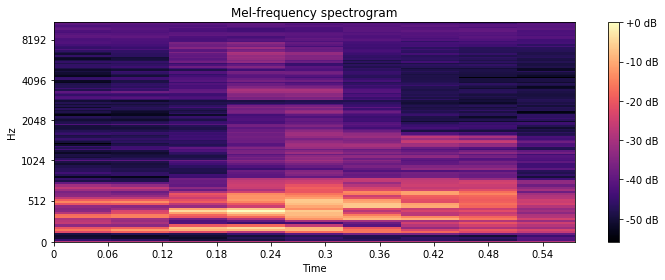

In [0]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

def plot_spec(S_dB):
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr)
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel-frequency spectrogram')
  plt.tight_layout()
  plt.show()
plot_spec(s_dB)

###Prétraitement et enregistrement des fichiers audios en mel-spectrogramme


Définition des fonctions utilisées pour le prétraitement

In [0]:
n_mels=128
sr = 8000


def compute_spectrogram(path):
    "Calcule le melspectrogramme du fichier audio situé à path dans le repertoire de fichiers"
    file_name = os.path.basename(path) 
    s , _ = librosa.load(path, sr= sr) # sr est le taux d'échantillonnage du signal.
    
    melspec = librosa.feature.melspectrogram(y=s, sr=sr, n_mels=n_mels)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    melspec_db_image = melspec_db.reshape(melspec_db.shape[0],melspec_db.shape[1],1) # on rajoute la dimension 1 à la fin pour forcer la représentation en tant qu'image (hauteur, largeur, nombre de couleurs ici égale à 1)
    return (path,melspec_db_image)

def get_duration(spec):
  "Renvoie la dimension correspondant à l'axe temporel d'un melspectrogramme"
  return spec.shape[1]

def get_longest_duration(list_path_spec):
  "Renvoie la dimension temporelle du melspectrogramme le plus long"
  list_time = [get_duration(spec) for path, spec in list_path_spec ]
  return max(list_time)

def save_melspec(path_melspec): 
    """
    Permet d'enregistrer les spectrogrammes dans le dossier melspectrogram
    """
    path, melspec = path_melspec
    file_name = os.path.basename(path)
    melspec_path = os.path.join("/content/melspectrogram", os.path.splitext(file_name)[0])
    np.save(melspec_path, melspec)
    #print("{} saved".format(melspec_path))


Le prétraitement et l'enregistrement des melspectrogrammes prend quelques minutes

In [0]:
import os
from tqdm.autonotebook import tqdm # bar de remplissage pour visualiser l'évolution du calcul et de l'enregistrement des spectrogrammes
import sys
import tensorflow as tf
n=n_files



print("Conversion des fichiers audio en melspectrogrammes")
list_spec = []
for path, spec in tqdm(map(compute_spectrogram, list_of_files[:n]), total=n):
   list_spec.append((path, spec))
   

max_time = get_longest_duration(list_spec)
print("La plus longue dimension temporelle est {}".format(max_time))
def spec_padding(path_data):
  path, spec = path_data
  min_spec = np.min(spec)
  spec_padded = np.pad(spec, ((0,0),(0,max_time-spec.shape[1]),(0,0)),"constant",constant_values=((min_spec,min_spec),(min_spec,min_spec),(min_spec,min_spec)))
  return (path, spec_padded)



print("Traitement des melspectrogrammes pour qu'ils aient la même durée")
list_padded_spec = []
for path, spec_padded in tqdm(map(spec_padding, list_spec[:n]), total=n):
  list_padded_spec.append((path,spec_padded))
  


print("Traitement des melspectrogrammes pour qu'ils aient la même durée")
for spec in tqdm(map(save_melspec, list_padded_spec[:n]), total=n):
  pass


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Conversion des fichiers audio en melspectrogrammes



La plus longue dimension temporelle est 36
Traitement des melspectrogrammes pour qu'ils aient la même durée



Traitement des melspectrogrammes pour qu'ils aient la même durée


# Votre travail

## Importation des fichiers

In [0]:
import os
import random
noms_fichiers = os.listdir('melspectrogram/')

In [0]:
def importer(nom):
  data = np.load('melspectrogram/'+nom)
  infos = nom[0:-4]
  infos = infos.split("_")
  infos[0] = int(infos[0]) # Conversion des strings en nombres
  infos[2] = int(infos[2])
  if infos[1] == 'jackson':
    infos[1] = [1,0,0,0]
  elif infos[1] == 'nicolas':
    infos[1] = [0,1,0,0]
  elif infos[1] == 'theo':
    infos[1] = [0,0,1,0]
  elif infos[1] == 'yweweler':
    infos[1] = [0,0,0,1]
  return data, infos

## Création du modèle

### Fonctions de calcul appelées dans la fonction d'optimisation

In [0]:
# Fonction calculant la moyenne de la dérivée de la variation de précision (vitesse d'évolution moyenne)

def atteinte_90(history):
  if history.history['acc'][-1] < 0.9:
    return
  i = len(history.history['acc'])-1
  while history.history['acc'][i] > 0.9:
    i -= 1
  return i

# Fonction qui affiche le nombre d'éléments dans chaque classe (on veut 1/4 des données)
# Inutilisée par la suite (mais peut être utile)

def verif_repartition(y_train):
    un = 0
    deux = 0
    trois = 0
    quatre = 0
    for i in range(len(y_train)):
      if y_train[i][0] == 1:
        un += 1
      elif y_train[i][1] == 1:
        deux += 1
      elif y_train[i][2] == 1:
        trois += 1
      elif y_train[i][3] == 1:
        quatre += 1
    print('REPARTITION DES CLASSES')
    print ('1 :'+str(un)+'\n2 :'+str(deux)+'\n3 :'+str(trois)+'\n4 :'+str(quatre))

# Création des données d'entrainement
def creer_X_Y(noms_fichiers):
  X,Y = [],[]
  for i in range(len(noms_fichiers)):
    data,infos = importer(noms_fichiers[i])
    X.append(data)
    Y.append(infos[1])
  return np.asarray(X),np.asarray(Y)



### Fonction qui crée un modèle avec des paramètres

In [0]:
import keras
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split


def nouveau_modele(nb_conv2D,epoques,BS,pourcentage_test):
  
  X,Y = creer_X_Y(noms_fichiers)
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=pourcentage_test)

  # create model
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 36, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # Convolutions
  for i in range(nb_conv2D):
    model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])

  history = model.fit(np.asarray(x_train), np.asarray(y_train), epochs=epoques, batch_size=BS, verbose = 1)

  evaluate = model.evaluate(np.asarray(x_test),np.asarray(y_test))

  prediction = model.predict(x_test)

  dernier_atteinte_90 = atteinte_90(history)

  # Dans le return il y a un _ à la place de xtest, ytest et prediction, version précédente qui était trop gourmande
  # je n'ai pas eu le temps de changer la suite donc cette solution de fortune est moins gourmande mais inutile (histoire d'index appelées dans la suite)
  return _, _, model, history.history, evaluate, _, dernier_atteinte_90

## Test itératif des critères

In [0]:
import numpy as np
from google.colab import files

def opti_gourmand(iteration):
  max_conv2D = 4 # doit rester inférieur à 8 (experience)
  max_epoques = 300
  max_BS = 0.9
  max_pourcentage_test = 0.8 # Valeurs sur le site de M.Gibaru : [0.6,0.8]

  resultats = []
  i = -1
  compteur = 0
  for nb_conv2D in np.arange(2,max_conv2D,2):
    i += 1
    j = -1
    resultats.append([])
    for epoques in np.arange(50,max_epoques,(max_epoques-50)//3):
      j += 1
      k = -1
      resultats[i].append([])
      for BS in np.arange(0.04,max_BS,(max_BS-0.01)/4):
        k += 1
        resultats[i][j].append([])
        for pourcentage_test in np.arange(0.6,max_pourcentage_test,(max_pourcentage_test-0.1)/3):
          resultats[i][j][k].append(nouveau_modele(int(nb_conv2D),int(epoques),int(BS*pourcentage_test*2000),pourcentage_test))
  return resultats

resultats = opti_gourmand(3)

def opti_simple():
  ntest = 4
  max_conv2D = 7
  max_epoques = 200
  max_BS = 0.9
  max_pourcentage_test = 0.95
  res_conv2D = []
  res_epoques = []
  res_BS =[]
  res_pourcentage_test = []
  for i in np.arange(1,max_epoques,200//6):
    res_epoques.append(nouveau_modele(4,i,32,0.8))
    print(str(i))
  return res_epoques

# resultats = opti_simple()

Epoch 1/50
800/800 [==============================] - 3s 4ms/step - loss: 2.8306 - acc: 0.2463
Epoch 2/50
800/800 [==============================] - 0s 366us/step - loss: 1.3702 - acc: 0.3150
Epoch 3/50
800/800 [==============================] - 0s 358us/step - loss: 1.3749 - acc: 0.2862
Epoch 4/50
800/800 [==============================] - 0s 352us/step - loss: 1.3319 - acc: 0.3375
Epoch 5/50
800/800 [==============================] - 0s 357us/step - loss: 1.2825 - acc: 0.3975
Epoch 6/50
800/800 [==============================] - 0s 371us/step - loss: 1.2482 - acc: 0.4037
Epoch 7/50
800/800 [==============================] - 0s 364us/step - loss: 1.1645 - acc: 0.4475
Epoch 8/50
800/800 [==============================] - 0s 361us/step - loss: 1.1458 - acc: 0.4700
Epoch 9/50
800/800 [==============================] - 0s 350us/step - loss: 1.1012 - acc: 0.5025
Epoch 10/50
800/800 [==============================] - 0s 363us/step - loss: 1.0818 - acc: 0.5437
Epoch 11/50
800/800 [==========

# Recherche d'un optimum en fonction de différents critères

In [0]:
def convergence_la_plus_rapide_gour():
  index = []
  min_dernier_atteinte_90 = resultats[0][0][0][0][6]
  for a in range(len(resultats)):
    for b in range(len(resultats[a])):
      for c in range(len(resultats[a][b])):
        for d in range(len(resultats[a][b][c])):
          if resultats[a][b][c][d][6] < min_dernier_atteinte_90: # Si la valeur de dernier_atteinte_90 pour le jeu de paramètres choisis est la plus basse, on conserve l'index correspondant de la liste resultats (il indique le jeu optimal pour ce critère)
            index = [(a,b,c,d)]
            min_dernier_atteinte_90 = resultats[a][b][c][d][6]
          elif resultats[a][b][c][d][6] == min_dernier_atteinte_90: # On peut trouver plusieurs possibilités
            index.append((a,b,c,d))
  print('On obtient la convergence la plus rapide avec le(s) jeu(x) de paramètres : '+str(index))
  print('Avec la dernière atteinte de 90% de précision au bout de '+str(min_dernier_atteinte_90)+' époques !')
  return


# convergence_la_plus_rapide_gour()

print('')

def meilleur_acc_gour(): # Fonction qui affiche l'index du jeu de paramètre idéal et la valeur maximale de précision atteinte
  index = []
  meilleur_acc = 0
  for a in range(len(resultats)):
    for b in range(len(resultats[a])):
      for c in range(len(resultats[a][b])):
        for d in range(len(resultats[a][b][c])):
          if resultats[a][b][c][d][4][1] > meilleur_acc: 
            index = [(a,b,c,d)]
            meilleur_acc = resultats[a][b][c][d][4][1]
          elif resultats[a][b][c][d][4][1] == meilleur_acc: # On peut trouver plusieurs possibilités
            index.append((a,b,c,d))
  print('On obtient la meilleure précision avec le(s) jeu(x) de paramètres : '+str(index))
  print('Avec une précision de '+str(meilleur_acc)+' !')
  return

  print('On obtient la meilleure précision avec le(s) jeu(x) de paramètres : '+str(index))
  print('Avec une précision de '+str(meilleur_acc)+' !')
  return

meilleur_acc_sim()
# meilleur_acc_gour()
print('')

def meilleur_loss(): 
  index = []
  meilleur_loss = 100
  for a in range(len(resultats)):
    for b in range(len(resultats[a])):
      for c in range(len(resultats[a][b])):
        for d in range(len(resultats[a][b][c])):
          if resultats[a][b][c][d][4][0] < meilleur_loss: 
            index = [(a,b,c,d)]
            meilleur_loss = resultats[a][b][c][d][4][1]
          elif resultats[a][b][c][d][4][1] == meilleur_loss: # On peut trouver plusieurs possibilités
            index.append((a,b,c,d))
  print('On obtient le meilleur loss avec le(s) jeu(x) de paramètres : '+str(index))
  print('Avec un loss de '+str(meilleur_loss)+' !')
  return

# meilleur_loss_gour()
print('')

def le_plus_overfit_gour(): 
  index = []
  max_overfit = 0
  for a in range(len(resultats)):
    for b in range(len(resultats[a])):
      for c in range(len(resultats[a][b])):
        for d in range(len(resultats[a][b][c])):
          overfit = abs(resultats[a][b][c][d][3]['acc'][-1]-resultats[a][b][c][d][4][1])
          if overfit > max_overfit: 
            index = [(a,b,c,d)]
            max_overfit = overfit
          elif overfit == max_overfit: # On peut trouver plusieurs possibilités
            index.append((a,b,c,d))
  print('On obtient le plus grand overfitting avec le(s) jeu(x) de paramètres : '+str(index))
  print("Avec un critère d'overfitting de "+str(max_overfit)+' !')
  return

# le_plus_overfit_gour()


NameError: ignored

### Graphiques

In [0]:
import matplotlib.pyplot as plt

# Tracés des effets des différentes variations des 4 paramètres avec la meilleure config de précision

# Variation du nombre d'époques (cf avant : C2D=2 ; epochs = 148 idéalement ? ; BS = 0,27 ; %test = 0.2)

epoques = []
accuracy = []
for i in range(len(resultats[0])):
  accuracy.append(resultats[0][i][1][0][4][1]) # Valeur de la précision
  epoques.append(50+i*(200-1)//3)

plt.plot(epoques,accuracy)
plt.xlabel("nombre d'époques")
plt.ylabel('accuracy')
plt.show()

# Variation du Batch Size (cf avant : C2D=2 ; epochs = 148 ; BS = 0,27 ? ; %test = 0.2)

batchsize = []
accuracy = []
for i in range(len(resultats[0][2])):
  accuracy.append(resultats[0][2][i][0][4][1]) # Valeur de la précision
  batchsize.append((0.01+i*(0.8-0.01)/3)*0.2*2000)

plt.plot(batchsize,accuracy)
plt.xlabel('Batch Size')
plt.ylabel('accuracy')
plt.show()
# Variation du %test (cf avant : C2D=2 ; epochs = 148 ; BS = 0,27 ; %test = 0.2 ?)

pourc_test = []
accuracy = []
for i in range(len(resultats[0][2][1])):
  accuracy.append(resultats[0][2][1][i][4][1]) # Valeur de la précision
  pourc_test.append(0.2+i*(0.9-0.2)/3)

plt.plot(pourc_test,accuracy)
plt.xlabel('pourcentage utilisé pour tester')
plt.ylabel('accuracy')
plt.show()

## Matrice de confusion

### Fonction qui crée la matrice de confusion

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def mat_conf(cm): 
  df_cm = pd.DataFrame(cm, index = [i for i in ["jackson","nicolas","theo","yweweler"]],
                       columns = [i for i in ["jackson","nicolas","theo","yweweler"]])
  plt.figure(figsize = (10,7))
  return sn.heatmap(df_cm, annot=True,fmt='g')

  

### Adaptation des arrays de prédiction retournés par le modèle au bon format pour la matrice de confusion

In [0]:
# Fonction qui prend la liste sous la forme [[0.000001,0.000001,0.9999,0.0001],...] et qui retourne [[0,0,1,0],...]
def adapter_Y_pred(Y_pred):
  for i in range(len(Y_pred)):
    imax = list(Y_pred[i]).index(max(list(Y_pred[i])))
    Y_pred[i][imax]= 1
    for k in range(len(Y_pred[i])):
      if Y_pred[i][k] != 1:
        Y_pred[i][k]=0

# Fonction qui prend un array de résultats prédits sous la forme [[0,0,1,0],...] et qui retourne [3,...]
def adapter(L):
  LS = []
  for i in range(len(L)):
    LS.append(list(L[i]).index(max(list(L[i]))))
  return LS

Y_test_mat = adapter(y_test)
Y_pred_mat = adapter(prediction)

NameError: ignored

### Création de la matrice de confusion

In [0]:
from sklearn import metrics
cm = confusion_matrix(Y_test_mat,Y_pred_mat)
mat_conf(cm)

NameError: ignored

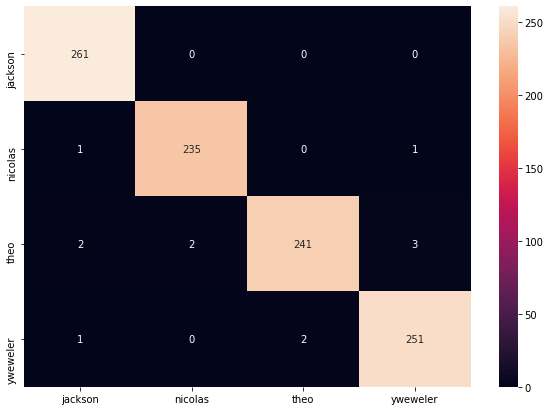

In [0]:
mat_conf(matrice)

## Schéma du modèle

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)